In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

"""Change to the data folder"""
new_path = "./new_train/new_train"
#new_path = r"C:\Users\mnisyu\Desktop\CSE151B competition\cse151b-spring\\"
#new_path = ".."

# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

### Create a dataset class 

In [3]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
val_dataset  = ArgoverseDataset(data_path=new_path)

In [9]:
len(val_dataset)

205942

In [6]:
test_dataset = ArgoverseDataset(data_path="./new_val_in/new_val_in")

In [10]:
len(test_dataset)

3200

### Create a loader to enable batch processing

In [12]:
batch_sz = 4

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
    inp = torch.LongTensor(inp)
    out = torch.LongTensor(out)
    return [inp, out]

val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0)

In [65]:
#a, b = next(iter(val_loader))
len(a) # 4 batches/scenes
len(b) # 4 batches/scenees
len(a[0]) # 60 vehicles
len(b[0]) # 60 vehicles
len(a[0][0]) # 19 timestamps
len(b[0][0]) # 30 timestamps


30

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

In [19]:
class Encoder(nn.Module):

    def __init__(self, input_size, hidden_dim, num_layers=1):
        super(Encoder, self).__init__()

        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.input_size, self.hidden_dim, num_layers=self.num_layers)
        self.hidden = None

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))

    def forward(self, inputs):
        # Push through RNN layer (the ouput is irrelevant)
        _, self.hidden = self.lstm(inputs, self.hidden)
        return self.hidden

In [20]:
class Decoder(nn.Module):

    def __init__(self, hidden_dim, num_layers=1):
        super(Decoder, self).__init__()
        # input_size=1 since the output are single values
        self.lstm = nn.LSTM(1, hidden_dim, num_layers=num_layers)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, outputs, hidden, criterion):
        batch_size, num_steps = outputs.shape
        # Create initial start value/token
        input = torch.tensor([[0.0]] * batch_size, dtype=torch.float)
        # Convert (batch_size, output_size) to (seq_len, batch_size, output_size)
        input = input.unsqueeze(0)

        loss = 0
        for i in range(num_steps):
            # Push current input through LSTM: (seq_len=1, batch_size, input_size=1)
            output, hidden = self.lstm(input, hidden)
            # Push the output of last step through linear layer; returns (batch_size, 1)
            output = self.out(output[-1])
            # Generate input for next step by adding seq_len dimension (see above)
            input = output.unsqueeze(0)
            # Compute loss between predicted value and true value
            loss += criterion(output, outputs[:, i])
        return loss

In [21]:
if __name__ == '__main__':

    # 5 is the number of features of your data points
    encoder = Encoder(5, 128)
    decoder = Decoder(128)
    # Create optimizers for encoder and decoder
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Some toy data: 2 sequences of length 10 with 5 features for each data point
    inputs = [
        [
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
        ],
        [
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
        ]
    ]

    inputs = torch.tensor(np.array(inputs), dtype=torch.float)
    # Convert (batch_size, seq_len, input_size) to (seq_len, batch_size, input_size)
    inputs = inputs.transpose(1,0)

    # 2 sequences (to match the batch size) of length 6 (for the 6h into the future)
    outputs = [ [0.1, 0.2, 0.3, 0.1, 0.2, 0.3], [0.3, 0.2, 0.1, 0.3, 0.2, 0.1] ]
    outputs = torch.tensor(np.array(outputs), dtype=torch.float)

    #
    # Do one complete forward & backward pass
    #
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    # Reset hidden state of encoder for current batch
    encoder.hidden = encoder.init_hidden(inputs.shape[1])
    # Do forward pass through encoder
    hidden = encoder(inputs)
    # Do forward pass through decoder (decoder gets hidden state from encoder)
    loss = decoder(outputs, hidden, criterion)
    # Backpropagation
    loss.backward()
    # Update parameters
    encoder_optimizer.step()
    decoder_optimizer.step()
    print("Loss:", loss.item())

Loss: 0.44670340418815613


C:\Users\mnisyu\anaconda3\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [59]:
a[0].size()

torch.Size([60, 19, 4])

In [60]:
a[0][0].size()

torch.Size([19, 4])

In [69]:
a[0][0][0]

tensor([3277, 1947,    0,    0])

In [76]:
input_dim = 4
hidden_dim = 10
n_layers = 1
lstm_layer = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)

In [77]:
batch_size = 1
seq_len = 1

inp = torch.randn(batch_size, seq_len, input_dim)
hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
cell_state = torch.randn(n_layers, batch_size, hidden_dim)
hidden = (hidden_state, cell_state)

In [79]:
hidden

(tensor([[[-0.2699,  1.0593, -0.3922, -1.3150, -0.8106,  0.8438,  1.9791,
           -0.3544,  1.3327, -0.8712]]]),
 tensor([[[-0.4122, -0.9752, -0.8629, -0.8413,  1.5831, -1.3641,  1.2202,
           -1.5006,  1.1591,  1.6278]]]))

In [71]:
dataset

array([[  0,   5,   5],
       [ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

### Visualize the batch of sequences

<ipython-input-13-e34a6e23e746>:7: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  inp = torch.LongTensor(inp)
<ipython-input-13-e34a6e23e746>:8: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  out = torch.LongTensor(out)


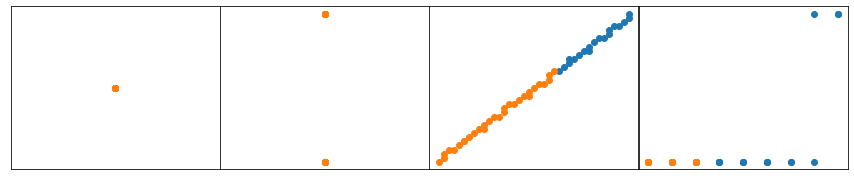

In [15]:
import matplotlib.pyplot as plt
import random

agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

        
for i_batch, sample_batch in enumerate(val_loader):
    inp, out = sample_batch
    """TODO:
      Deep learning model
      training routine
    """
    show_sample_batch(sample_batch, agent_id)
    break